In [1]:
import os, sys
import glob
import time     
import subprocess
import multiprocessing

In [2]:
CWD = os.getcwd()

try:
    from pfabnet import utils
except ModuleNotFoundError as e:
    os.chdir(os.getcwd() + os.sep + '..')
    
from pfabnet import utils
from pfabnet import base
from pfabnet.base import SCHRODINGER_BASE

In [3]:
NUM_PROCESSORS = multiprocessing.cpu_count()
if NUM_PROCESSORS > 6:
    NUM_PROCESSORS = 6
    
print('Homology models will be built using %d processors' % NUM_PROCESSORS)

Homology models will be built using 6 processors


In [4]:
BASE_DIR = os.path.dirname(base.get_file_path()) + '/../'
DATA_DIR = os.path.join(BASE_DIR, 'data')
FASTA_DIR = os.path.join(DATA_DIR, 'fasta')
HM_DIR = os.path.join(DATA_DIR, 'hm')
HM10_DIR = os.path.join(DATA_DIR, 'hm10')

In [5]:
def run_antibody_builder_base(cmd):
    try:
        subprocess.check_call(cmd, shell=True)
    except Exception as e:
        print(e)

def run_antibody_builder(cmd_list):
    if len(cmd_list) == 0:
        return
    print('Running antibody builder...')
    p = multiprocessing.Pool(processes=NUM_PROCESSORS)
    p.map(run_antibody_builder_base, cmd_list)
    p.close()

def convert_maegz(structs='1:1', out_dir='./'):
    maegz_files = glob.glob('*-out.maegz')
    for maegz_file in maegz_files:
        pdb_file = maegz_file.split('-out.maegz')[0] + '.pdb'
        cmd_convert_pdb = SCHRODINGER_BASE + '/utilities/pdbconvert -n %s -imae %s -opdb %s/%s' % (structs, maegz_file, out_dir, pdb_file)
        mol2_file = maegz_file.split('-out.maegz')[0] + '.mol2'
        cmd_convert_mol2 = SCHRODINGER_BASE + '/utilities/mol2convert -n %s -imae %s -omol2 %s/%s' % (structs, maegz_file, out_dir, mol2_file)
        sd_file = maegz_file.split('-out.maegz')[0] + '.sdf'
        cmd_convert_sdf = SCHRODINGER_BASE + '/utilities/sdconvert -n %s -imae %s -osd %s/%s' % (structs, maegz_file, out_dir, sd_file)
        
        try:
            subprocess.check_call(cmd_convert_pdb, shell=True)
            subprocess.check_call(cmd_convert_mol2, shell=True)
            subprocess.check_call(cmd_convert_sdf, shell=True)
        except Exception as e:
            pass


In [26]:
hm_cmd_base = SCHRODINGER_BASE + '/run -FROM bioluminate build_antibody.py -nmodel 1 -HOST localhost -WAIT '

os.makedirs(HM_DIR, exist_ok=True)
os.chdir(HM_DIR)

fasta_files = glob.glob(FASTA_DIR + os.sep + '*.fasta')
hm_cmd_list = []
for fasta_file in fasta_files:
    hm_cmd = hm_cmd_base + fasta_file
        
    hm_cmd_list.append(hm_cmd)

run_antibody_builder(hm_cmd_list)
convert_maegz()

os.chdir(CWD)

In [11]:
hm_cmd_base = SCHRODINGER_BASE + '/run -FROM bioluminate build_antibody.py -nmodel 10 -HOST localhost -WAIT '

os.makedirs(HM10_DIR, exist_ok=True)
os.chdir(HM10_DIR)

fasta_files = glob.glob(FASTA_DIR + os.sep + '*.fasta')
hm_cmd_list = []
for fasta_file in fasta_files:
    hm_cmd = hm_cmd_base + fasta_file
    hm_cmd_list.append(hm_cmd)

run_antibody_builder(hm_cmd_list)

os.chdir(CWD)

Running antibody builder...
Antibody Template Search obj initialization ...  done - 0.54 seconds. 
Antibody Template Search obj initialization ...  done - 0.54 seconds. 
Antibody Template Search obj initialization ...  done - 0.59 seconds. 
Antibody Template Search obj initialization ...  done - 0.59 seconds. 
Antibody Template Search obj initialization ...  done - 0.58 seconds. 
Antibody Template Search obj initialization ...  done - 0.59 seconds. 
Antibody Template Search obj initialization ...  done - 0.59 seconds. 
JobId: i006-3-62f3e3ca
Antibody Template Search obj initialization ...  done - 0.59 seconds. 
JobId: i006-5-62f3e3ca
Antibody Template Search obj initialization ...  done - 0.56 seconds. 
Antibody Template Search obj initialization ...  done - 0.58 seconds. 
Antibody Template Search obj initialization ...  done - 0.59 seconds. 
JobId: i006-2-62f3e3ca
Antibody Template Search obj initialization ...  done - 0.56 seconds. 
JobId: i006-1-62f3e3ca
Antibody Template Search obj

In [13]:
# extract and convert individual homology models from .maegz files
os.chdir(HM10_DIR)
for i in range(1, 11):
    os.makedirs('struct_%d' % i, exist_ok=True)
    convert_maegz('%d:%d' % (i, i), 'struct_%d' % i)
    
os.chdir(CWD)

## Intra- and inter-group similarity of the Ab21 and PDGF antibodies

In [23]:
from pfabnet.base import ENTITY_KEY, VISCOSITY_KEY

import os, sys
import pandas as pd
import numpy as np
import pickle
import glob
import collections

from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample

from openeye import oechem

from textwrap import wrap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

%matplotlib inline

%config IPCompleter.greedy=True

def get_molecule(f):
    ifs = oechem.oemolistream(f)
    mol = oechem.OEGraphMol()
    oechem.OEReadMolecule(ifs, mol)
    ifs.close()
    
    return mol

L1_KEY = 'L1'
L2_KEY = 'L2'
L3_KEY = 'L3'
H1_KEY = 'H1'
H2_KEY = 'H2'
H3_KEY = 'H3'

def get_segment_residue_keys(protein_mol, protein_sdmol, sdkey):
    try:
        value = oechem.OEGetSDData(protein_sdmol, sdkey)
        res_start, res_end = value.split('_')
        res_start = res_start.replace(':', '')
        res_end = res_end.replace(':', '')

        segment_residues = [res_start]
        hv = oechem.OEHierView(protein_mol)
        include_residue = False
        for hr in hv.GetResidues():
            oeres = hr.GetOEResidue()
            resnum = oeres.GetResidueNumber()
            reskey = oeres.GetChainID() + str(resnum)
            if reskey == res_start:
                include_residue = True
                continue
            if reskey == res_end:
                break
            if include_residue:
                segment_residues.append(reskey)
        segment_residues.append(reskey)

        return segment_residues
    except Exception as e:
        return []
    
    

def extract_segment_data(protein_mol, protein_sdfile):        
    protein_sdmol = get_molecule(protein_sdfile)

    L1_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_L1_Chothia')
    L2_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_L2_Chothia')
    L3_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_L3_Chothia')
    H1_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_H1_Chothia')
    H2_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_H2_Chothia')
    H3_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_H3_Chothia')   
    
    return {L1_KEY:L1_residues, L2_KEY:L2_residues, L3_KEY:L3_residues, H1_KEY:H1_residues, H2_KEY:H2_residues, H3_KEY:H3_residues}


def get_Chothia_data(pdb_files):
    site_aa_variability = collections.defaultdict(list)
    site_residues = []
    cdr_residues = collections.defaultdict(list)
    for pdb_file in pdb_files:
        mol = get_molecule(pdb_file)
        hv = oechem.OEHierView(mol)
        site_residue_map = {}
        for hr in hv.GetResidues():
            oeres = hr.GetOEResidue()
            reskey = oeres.GetChainID() + str(oeres.GetResidueNumber())
            aa = oeres.GetName()
            
            site_residue_map[reskey] = aa
            if aa not in site_aa_variability[reskey]:
                site_aa_variability[reskey].append(aa)
                
        site_residues.append((os.path.basename(pdb_file), site_residue_map))
        
        sdfile = pdb_file.split('.pdb')[0] + '.sdf'
        cdr_residues_cur = extract_segment_data(mol, sdfile)
        for k, v in cdr_residues_cur.items():
            for elem in v:
                if elem not in cdr_residues[k]:
                    cdr_residues[k].append(elem)
        
    site_aa_variability2 = {}
    for k, v in site_aa_variability.items():
        if len(v) > 1:
            site_aa_variability2[k] = v
            
    return site_residues, site_aa_variability2, cdr_residues

def get_dataset_similarity(dataset1, cdr_residues1, dataset2, ignore_identity=False):
    sim_output = []
    for name, site_residue_map in dataset1:
        min_distance = 1e10; min_cdr_distance = None
        for name2, site_residue_map2 in dataset2:
            distance = 0; cdr_distance = collections.defaultdict(int)
            for k, aa in site_residue_map.items():
                if (k not in site_residue_map2) or (aa != site_residue_map2[k]):
                    distance += 1
                    for cdr, cur_cdr_residues in cdr_residues1.items():
                        if k in cur_cdr_residues:
                            cdr_distance[cdr] += 1
                    continue
                    
            if distance == 0 and ignore_identity:
                continue
            if distance < min_distance:
                min_distance = distance
                min_cdr_distance = cdr_distance
                
        all_cdr_distance = 0
        for k, v in min_cdr_distance.items():
            all_cdr_distance += v
        sim_output.append((name, min_distance-all_cdr_distance, min_cdr_distance))
        
    return sim_output


def plot_dataset_similarity(ax, sim_output, label_x, label_y, y_pad=0, legend=None):
    FONT_SIZE = 16
    
    data = np.array([c for _, c, _ in sim_output])
    
    L1_data = np.array([cdr_data[L1_KEY] for _, _, cdr_data in sim_output])
    L2_data = np.array([cdr_data[L2_KEY] for _, _, cdr_data in sim_output])
    L3_data = np.array([cdr_data[L3_KEY] for _, _, cdr_data in sim_output])
    H1_data = np.array([cdr_data[H1_KEY] for _, _, cdr_data in sim_output])
    H2_data = np.array([cdr_data[H2_KEY] for _, _, cdr_data in sim_output])
    H3_data = np.array([cdr_data[H3_KEY] for _, _, cdr_data in sim_output])
    
    ax.bar(np.arange(len(data)), data)
    ax.bar(np.arange(len(data)), L1_data, bottom=data)
    ax.bar(np.arange(len(data)), L2_data, bottom=data+L1_data)
    ax.bar(np.arange(len(data)), L3_data, bottom=data+L1_data+L2_data)
    ax.bar(np.arange(len(data)), H1_data, bottom=data+L1_data+L2_data+L3_data)
    ax.bar(np.arange(len(data)), H2_data, bottom=data+L1_data+L2_data+L3_data+H1_data)
    ax.bar(np.arange(len(data)), H3_data, bottom=data+L1_data+L2_data+L3_data+H1_data+H2_data)
    
    # ax.bar(np.arange(len(data)), data, bottom=data)
    ax.set_ylabel('Min Levenshtein distance to \n%s'%label_y, fontsize=FONT_SIZE)
    ax.set_xlabel(label_x, fontsize=FONT_SIZE)
    ax.get_xaxis().set_ticks([])
    if y_pad > 0:
        ax.set_ylim([0, max(data + L1_data + L2_data + L3_data + H1_data + H2_data + H3_data)+y_pad])
    
    if legend is not None:
        ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24)
        

def plot_viscosity(ax, df_visc, xlabel, ylabel):
    FONT_SIZE = 15
    
    data = [value for value in df_visc[VISCOSITY_KEY]]
    ax.plot(np.arange(0, len(data)+1)-0.5, [20]*(len(data)+1), 'g-')
    ax.bar(np.arange(len(data)), data)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_xlim([-0.5, len(data)-0.5])
    ax.get_xaxis().set_ticks([])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))   
    ax.set_yscale('log')
    
    
    
def plot_site_variability(ax, site_aa_variability, cdr_residues, ylabel):
    FONT_SIZE = 16
    
    data_L = [(int(pos[1:]), pos[0], pos, len(item)) for pos, item in site_aa_variability.items() if pos[0] == 'L']
    data_L.sort()
    data_H = [(int(pos[1:]), pos[0], pos, len(item)) for pos, item in site_aa_variability.items() if pos[0] == 'H']
    data_H.sort()
    data_L.extend(data_H)
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    default_colors = prop_cycle.by_key()['color']
    
    color_map = {L1_KEY:default_colors[1], L2_KEY:default_colors[2], 
                 L3_KEY:default_colors[3], H1_KEY:default_colors[4], 
                 H2_KEY:default_colors[5], H3_KEY:default_colors[6]}
    colors = []
    for _, _, pos, _ in data_L:
        color = default_colors[0]
        for k, v in cdr_residues.items():
            if pos in v:
                color = color_map[k]
                break
        colors.append(color)
    
    data = [count for _, _, _, count in data_L]
    ax.bar(np.arange(len(data)), data, color=colors)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.set_xlabel('Chothia site', fontsize=FONT_SIZE)
    ax.get_xaxis().set_ticks([])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    

In [18]:
pdb_files = glob.glob('data/hm/mAb*.pdb')
site_residues_ab21, site_aa_variability_ab21, cdr_residues_ab21 = get_Chothia_data(pdb_files)

pdb_files = glob.glob('data/hm/*.pdb')
pdb_files = [pdb_file for pdb_file in pdb_files if 'mAb' not in pdb_file]
site_residues_pdgf38, site_aa_variability_pdgf38, cdr_residues_pdgf38 = get_Chothia_data(pdb_files)

In [19]:
sim_output_ab21_pdgf38 = get_dataset_similarity(site_residues_ab21, cdr_residues_ab21, site_residues_pdgf38, True)
sim_output_pdgf38_ab21 = get_dataset_similarity(site_residues_pdgf38, cdr_residues_pdgf38, site_residues_ab21, True)
sim_output_intra_ab21 = get_dataset_similarity(site_residues_ab21, cdr_residues_ab21, site_residues_ab21, True)

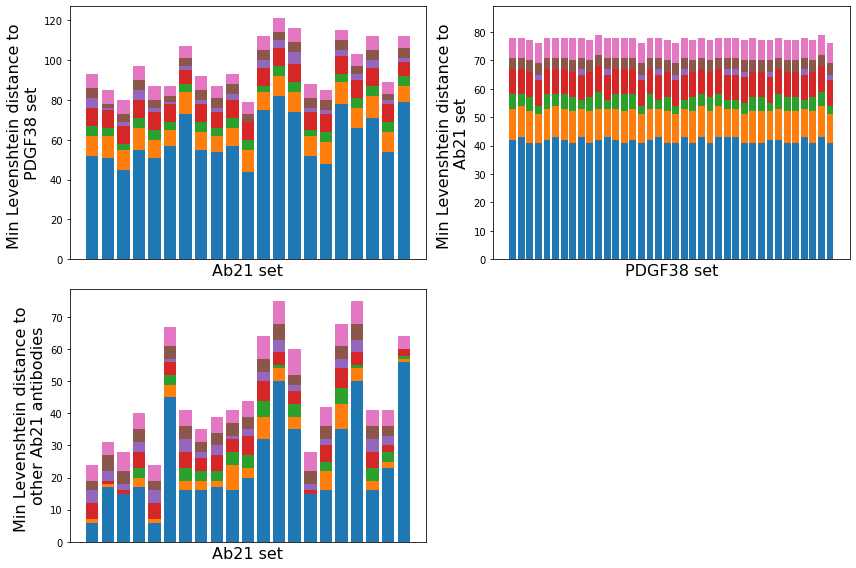

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_dataset_similarity(axs[0,0], sim_output_ab21_pdgf38, 'Ab21 set', 'PDGF38 set')
plot_dataset_similarity(axs[0,1], sim_output_pdgf38_ab21, 'PDGF38 set', 'Ab21 set', y_pad=10)
plot_dataset_similarity(axs[1,0], sim_output_intra_ab21, 'Ab21 set', 'other Ab21 antibodies', legend=None)
axs[1,1].axis('off')
plt.tight_layout()

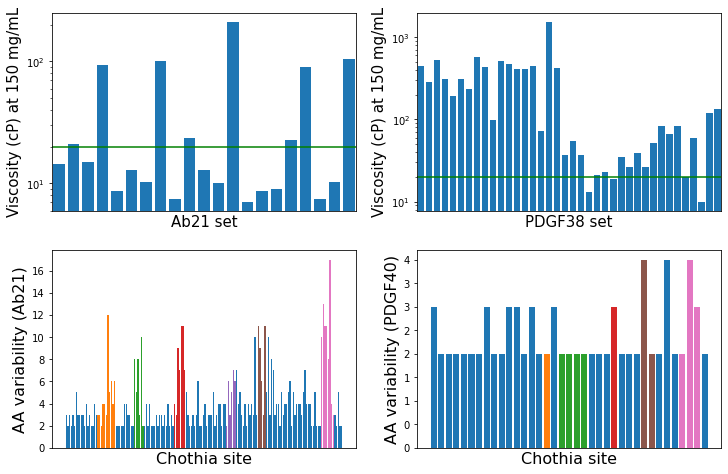

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_site_variability(axs[1,0], site_aa_variability_ab21, cdr_residues_ab21, 'AA variability (Ab21)')
plot_site_variability(axs[1,1], site_aa_variability_pdgf38, cdr_residues_pdgf38, 'AA variability (PDGF40)')

df_visc = pd.read_csv('data/Ab21.csv')
plot_viscosity(axs[0,0], df_visc, 'Ab21 set', 'Viscosity (cP) at 150 mg/mL')
df_visc = pd.read_csv('data/PDGF38.csv')
plot_viscosity(axs[0,1], df_visc, 'PDGF38 set', 'Viscosity (cP) at 150 mg/mL')